## Set Up Environment

In [1]:
# Mount your Google Drive to this notebook
# The purpose is to allow your code to access to your files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Change to the shared ECE5554 Computer Vision Final Project Folder.
import os
os.chdir('/content/drive/My Drive/VT/Fall 2023/ECE5554/Project')

## Import Kaggle dataset (Only need to do this if running for the first time.)

In [3]:
'''from google.colab import files
files.upload()'''

'from google.colab import files\nfiles.upload()'

In [4]:
'''!ls -lha kaggle.json'''
'''!ls -lha kaggle (2) (1).json'''

'!ls -lha kaggle (2) (1).json'

In [5]:
'''!pip install -q kaggle'''

'!pip install -q kaggle'

In [6]:
# The Kaggle API client expects this file to be in ~/.kaggle, so move it there.
! mkdir ~/.kaggle
#!mkdir -p ~/.kaggle
#!cp kaggle (2).json ~/.kaggle/
!cp kaggle.json ~/.kaggle/
#! cp kaggle(2)(1).json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
#!chmod 600 ~/.kaggle/kaggle (2).json
!chmod 600 ~/.kaggle/kaggle.json
#!chmod 600 ~/.kaggle/kaggle(2)(1).json

In [7]:
!kaggle datasets download -d dev523/leaf-disease-detection-dataset

leaf-disease-detection-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [8]:
'''!unzip leaf-disease-detection-dataset.zip'''

'!unzip leaf-disease-detection-dataset.zip'

In [9]:
train_dir = r'dataset/train'
test_dir  = r'dataset/test'

## Import Required Library Modules.

In [10]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import cv2
from google.colab.patches import cv2_imshow

##Preprocessing
Check Number of Classes and shapes for training and testing dataset.

In [11]:
num_classes = len(os.listdir(train_dir))
print(f"No. of Classes : {num_classes}")

No. of Classes : 38


In [12]:
for d in [train_dir, test_dir]:

    filepaths = []
    labels=[]
    classlist = sorted(os.listdir(d))

    for klass in classlist:
        label=klass.split('___')[1]
        classpath=os.path.join(d, klass)
        flist=sorted(os.listdir(classpath))

        for f in flist:
            fpath=os.path.join(classpath,f)
            filepaths.append(fpath)
            labels.append(label)

    Fseries=pd.Series(filepaths, name='filepaths')
    Lseries=pd.Series(labels, name='labels')

    if d == train_dir:
        train_df = pd.concat([Fseries, Lseries], axis=1)
    else:
        test_df = pd.concat([Fseries, Lseries], axis=1)

In [13]:
train_df.shape, test_df.shape

((16184, 2), (17572, 2))

In [14]:
test_df.head

<bound method NDFrame.head of                                                filepaths      labels
0      dataset/test/Apple___Apple_scab/00075aa8-d81a-...  Apple_scab
1      dataset/test/Apple___Apple_scab/00075aa8-d81a-...  Apple_scab
2      dataset/test/Apple___Apple_scab/00075aa8-d81a-...  Apple_scab
3      dataset/test/Apple___Apple_scab/01f3deaa-6143-...  Apple_scab
4      dataset/test/Apple___Apple_scab/0208f4eb-45a4-...  Apple_scab
...                                                  ...         ...
17567  dataset/test/Tomato___healthy/fd061d12-644d-4a...     healthy
17568  dataset/test/Tomato___healthy/fdbbea63-18e0-40...     healthy
17569  dataset/test/Tomato___healthy/fe0b76dc-4263-4c...     healthy
17570  dataset/test/Tomato___healthy/fe8f8808-2631-49...     healthy
17571  dataset/test/Tomato___healthy/ff8b36d5-feaf-4d...     healthy

[17572 rows x 2 columns]>

In [15]:
# get the number of classes and the images count for each class in train_df
classes=sorted(list(train_df['labels'].unique()))
class_count = len(classes)
print('The number of classes in the dataset is: ', class_count)
groups=train_df.groupby('labels')
print('{0:^30s} {1:^13s}'.format('CLASS', 'IMAGE COUNT'))
countlist=[]
classlist=[]
for label in sorted(list(train_df['labels'].unique())):
    group=groups.get_group(label)
    countlist.append(len(group))
    classlist.append(label)
    print('{0:^30s} {1:^13s}'.format(label, str(len(group))))


The number of classes in the dataset is:  7
            CLASS               IMAGE COUNT 
          Apple_scab               2016     
          Black_rot                1987     
       Cedar_apple_rust            1760     
Cercospora_leaf_spot Gray_leaf_spot     1642     
         Common_rust_              1446     
        Powdery_mildew             1683     
           healthy                 5650     


Want to only use 1000 random training and test samples. No validation datasets
will be provided for this implementation.

In [16]:
# lets get the average height and width of a sample of the train images
ht=0
wt=0

# select 1000 random samples of train_df
train_df_sample=train_df.sample(n=1500, random_state=123,axis=0)
test_df_sample=test_df.sample(n=1500, random_state=123,axis=0)
for i in range (len(train_df_sample)):
    fpath=train_df_sample['filepaths'].iloc[i]
    img=plt.imread(fpath)
    shape=img.shape
    ht += shape[0]
    wt += shape[1]

print('average height =', ht//100, ' average width =', wt//100, 'aspect ratio =', ht/wt)

average height = 3840  average width = 3840 aspect ratio = 1.0


In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [18]:
batch_size = 16
#batch_size = 32
target_size = (256, 256)
#target_size = (128, 128)

train_gen = ImageDataGenerator(rescale=None,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

test_gen = ImageDataGenerator(rescale=None,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

training_set = train_gen.flow_from_directory(train_dir,
                                               target_size=target_size,
                                               batch_size= batch_size,
                                               class_mode='categorical')


testing_set = test_gen.flow_from_directory(test_dir,
                                               target_size=target_size,
                                               batch_size=batch_size,
                                               class_mode='categorical')

Found 16184 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.


Showing Image Samples.

In [19]:
def show_image_samples(gen, set_name):
    t_dict = gen.class_indices
    classes = list(t_dict.keys())
    images,labels = next(gen)
    new_img_list = images.tolist()
    #img = cv2.resize(images, (80, 80))
    #img = (img/255.0).astype('float32')
    #new_img_list.append(img)

    # Plot Figures of different leaves.
    fig = plt.figure(figsize=(10, 10), facecolor='#d3d3d3')
    fig.suptitle(set_name, fontsize=16)
    fig.subplots_adjust(top=0.8)
    length = len(labels)
    if length < 9:
        r = length
    else:
        r = 9
    for i in range(r):
        plt.subplot(3, 3, i + 1)
        image=images[i] /255
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        print("class_name: ", class_name)
        plt.title(class_name, fontsize=12, alpha=0.8, color='#000088')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

show_image_samples(training_set, 'TRAINING IMAGES')
show_image_samples(testing_set, 'TESTING IMAGES')

Output hidden; open in https://colab.research.google.com to view.

In [20]:
train_df

,filepaths,labels
0,dataset/train/Apple___Apple_scab/00075aa8-d81a...,Apple_scab
1,dataset/train/Apple___Apple_scab/01a66316-0e98...,Apple_scab
2,dataset/train/Apple___Apple_scab/01a66316-0e98...,Apple_scab
3,dataset/train/Apple___Apple_scab/01a66316-0e98...,Apple_scab
4,dataset/train/Apple___Apple_scab/01a66316-0e98...,Apple_scab
...,...,...
16179,dataset/train/Corn_(maize)___Common_rust_/RS_R...,Common_rust_
16180,dataset/train/Corn_(maize)___Common_rust_/RS_R...,Common_rust_
16181,dataset/train/Corn_(maize)___Common_rust_/RS_R...,Common_rust_
16182,dataset/train/Corn_(maize)___Common_rust_/RS_R...,Common_rust_


In [21]:
train_df_sample

,filepaths,labels
2911,dataset/train/Apple___Black_rot/73fcc7b8-b884-...,Black_rot
1205,dataset/train/Apple___Apple_scab/9cbb6419-1670...,Apple_scab
5005,dataset/train/Apple___Cedar_apple_rust/92f2fe2...,Cedar_apple_rust
10358,dataset/train/Cherry_(including_sour)___Powder...,Powdery_mildew
10331,dataset/train/Cherry_(including_sour)___Powder...,Powdery_mildew
...,...,...
4295,dataset/train/Apple___Cedar_apple_rust/3839589...,Cedar_apple_rust
10810,dataset/train/Cherry_(including_sour)___Powder...,Powdery_mildew
4213,dataset/train/Apple___Cedar_apple_rust/27d7abb...,Cedar_apple_rust
7590,dataset/train/Apple___healthy/ec41f18f-cd53-43...,healthy


In [22]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
import random

Convert Leaf Disease filepaths to images using cv2.

In [23]:
def file_to_img(filepath):
  images = [];
  for i in range(len(filepath)):
    print("i: ", i)
    print("Current Filepath: ", filepath[i])
    current_img = cv2.imread(filepath[i])
    print("current_img shape: ", current_img.shape)
    current_img = cv2.resize(current_img, (128, 128))
    current_img = (current_img/255).astype('float32')
    images.append(current_img)
  return images

trained_images = train_df_sample.values.tolist()
print("trained_images: ", trained_images)
trained_filepaths = [trained_images[i][0] for i in range(len(trained_images))]
# Want binary classification if leaf is healthy or not. If leaf is healthy,
# classification receives 1.0 else receive 0.0 classification.
trained_labels = ['healthy' if trained_images[i][1] == 'healthy' else 'not healthy' for i in range(len(trained_images))]
train_df_sample['health_label'] = trained_labels

# creating DataFrame from targets_data
train_x = file_to_img(trained_filepaths)
#train_x = np.array(train_x)
print("type of train_x: ", type(train_x))
print("length of train_x: ", len(train_x))

trained_images:  [['dataset/train/Apple___Black_rot/73fcc7b8-b884-45ef-a52f-6ed6b2f93c27___JR_FrgE.S 8642_new30degFlipLR.JPG', 'Black_rot'], ['dataset/train/Apple___Apple_scab/9cbb6419-1670-45d5-a8ad-90cf9eaac971___FREC_Scab 3075.JPG', 'Apple_scab'], ['dataset/train/Apple___Cedar_apple_rust/92f2fe26-624c-4620-8210-0e2ff92e594d___FREC_C.Rust 4354_90deg.JPG', 'Cedar_apple_rust'], ['dataset/train/Cherry_(including_sour)___Powdery_mildew/76d8c7b8-2091-48bd-b169-37f3c739cc89___FREC_Pwd.M 4877_flipLR.JPG', 'Powdery_mildew'], ['dataset/train/Cherry_(including_sour)___Powdery_mildew/7153bd0f-847f-40a5-9252-cf1d2e0426c4___FREC_Pwd.M 4666_flipLR.JPG', 'Powdery_mildew'], ['dataset/train/Cherry_(including_sour)___Powdery_mildew/563b4d04-b28c-416c-8469-dc0ea1fdafd4___FREC_Pwd.M 5143.JPG', 'Powdery_mildew'], ['dataset/train/Cherry_(including_sour)___healthy/f9ece352-c99c-4d2f-a53f-9a7f88867d03___JR_HL 9874 copy_flipTB.JPG', 'healthy'], ['dataset/train/Blueberry___healthy/32ab02ea-840c-4750-b296-1492

In [24]:
health_check_train = [1.0 if train_df['labels'][i] == 'healthy' else 0.0 for i in range(len(trained_labels))]
print("length of train_y: ", len(health_check_train))
# Add binary 0/1 classification to train_df_sample
train_df_sample['health_label_num'] = health_check_train


# Convert train_x and train_y to tensor
train_x = torch.tensor(train_x)
#print("Shape train_x: ", train_x.shape)
train_x = train_x.reshape(train_x.shape[0], 3, train_x.shape[1], train_x.shape[2])
train_y = torch.tensor(health_check_train)
#print("Shape train_y: ", train_y.shape)
train_df_sample.head()

length of train_y:  1500


<ipython-input-24-75939d306666>:8: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  train_x = torch.tensor(train_x)


,filepaths,labels,health_label,health_label_num
2911,dataset/train/Apple___Black_rot/73fcc7b8-b884-...,Black_rot,not healthy,0.0
1205,dataset/train/Apple___Apple_scab/9cbb6419-1670...,Apple_scab,not healthy,0.0
5005,dataset/train/Apple___Cedar_apple_rust/92f2fe2...,Cedar_apple_rust,not healthy,0.0
10358,dataset/train/Cherry_(including_sour)___Powder...,Powdery_mildew,not healthy,0.0
10331,dataset/train/Cherry_(including_sour)___Powder...,Powdery_mildew,not healthy,0.0


## CNN Model and Training.

Set Up CNN Model using Basic PyTorch Architecture.

In [25]:
# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Hyper parameters
# Because GPU and TPU in Google Colab has a usage limit, may need to change the
# number of epochs.
#num_epochs = 5
num_epochs = 9 # Use for GPU and TPU
#num_epochs = 2 # Use for CPU.
num_classes =2 # Binary Classification
learning_rate = 0.001

In [26]:
 # Creating a CNN class
class ConvNet(nn.Module):
	#  Determine what layers and their order in CNN object
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv_layer1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3)
        self.bn1 = BatchNorm2d(batch_size)
        self.max_pool1 = nn.MaxPool2d(kernel_size = 3, stride = 2)
        self.relu1 = nn.ReLU()

        self.conv_layer2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3)
        self.bn2 = BatchNorm2d(2*batch_size)
        self.max_pool2 = nn.MaxPool2d(kernel_size = 3, stride = 2)
        self.relu2 = nn.ReLU()

        self.conv_layer3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.bn3 = BatchNorm2d(4*batch_size)
        self.max_pool3 = nn.MaxPool2d(kernel_size = 3, stride = 2)
        self.relu3 = nn.ReLU()

        BatchNorm2d(batch_size)

    # Progresses data across layers
    def forward(self, x):
        out = self.conv_layer1(x)
        out = self.bn1(out)
        out = self.max_pool1(out)
        out = self.relu1(out)
        out = self.conv_layer2(out)
        out = self.bn2(out)
        out = self.max_pool2(out)
        out = self.relu2(out)
        out = self.conv_layer3(out)
        out = self.bn3(out)
        out = self.max_pool3(out)
        out = self.relu3(out)
        out = out.reshape(out.size(0), -1)
        return out

Define the CNN Model.

In [27]:
# defining the model
model = ConvNet()
# defining the optimizer
optimizer = Adam(model.parameters(), lr=learning_rate)
print("optimizer: ", optimizer)
# defining the loss function
criterion = CrossEntropyLoss()
# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()

print("model: ", model)
train_losses = []
val_losses = []


optimizer:  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)
model:  ConvNet(
  (conv_layer1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (max_pool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu1): ReLU()
  (conv_layer2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (max_pool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu2): ReLU()
  (conv_layer3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (max_pool3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilati

Train the Model.

In [28]:
def train(epoch):
    model.train()
    tr_loss = 0
    # Getting the training set
    x_train, y_train = Variable(train_x), Variable(train_y)
    # getting the validation set
    # converting the data into GPU format
    if torch.cuda.is_available():
        x_train = x_train.cuda()
        y_train = y_train.cuda()
        #x_val = x_val.cuda()
        #y_val = y_val.cuda()


    # clearing the Gradients of the model parameters
    optimizer.zero_grad()

    # prediction for training and validation set
    output_train = model(x_train)

    # computing the training and validation loss
    loss_train = criterion(output_train, y_train.long())
    train_losses.append(loss_train)

    # computing the updated weights of all the model parameters
    loss_train.backward()
    optimizer.step()
    tr_loss = loss_train.item()
    print('Epoch : ',epoch+1, '\t', 'loss :', loss_train)
    return output_train, loss_train

# training the model
output_train_models = []; # output_val_models = [];
loss_values = [];
for epoch in range(num_epochs):
    # Given that a GPU would be required to train the model and time constraints,
    # the model will be trained for each epoch. After finishing, the epoch with
    # the highest loss value (loss_val) will be used for evaluation of the model.
    output_train_epoch, loss_train = train(epoch)
    output_train_models.append(output_train_epoch)
    loss_values.append(loss_train.item())


#print("loss_values: ", loss_values)
# Take output_train_model with highest loss value from loss_values list.
highest_val_loss = max(loss_values)
high_i = loss_values.index(highest_val_loss)

Epoch :  1 	 loss : tensor(9.7734, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch :  2 	 loss : tensor(9.4196, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch :  3 	 loss : tensor(9.2066, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch :  4 	 loss : tensor(9.1022, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch :  5 	 loss : tensor(9.0248, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch :  6 	 loss : tensor(8.9570, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch :  7 	 loss : tensor(8.8930, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch :  8 	 loss : tensor(8.8313, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch :  9 	 loss : tensor(8.7670, device='cuda:0', grad_fn=<NllLossBackward0>)


Plot of Loss of Epochs.

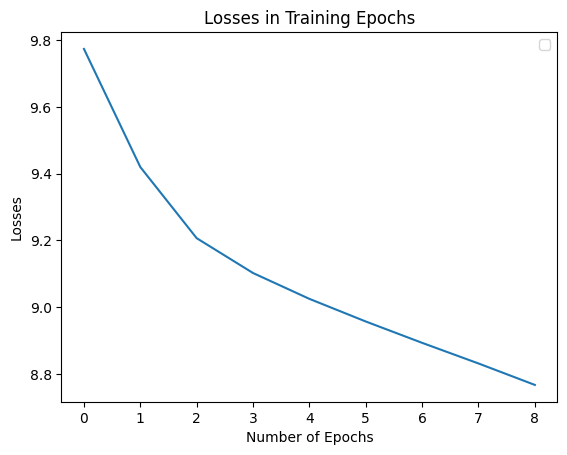

In [29]:
def detach(tensorlist):
    detached_list = []
    for i in range(len(tensorlist)):
        detached_list.append(tensorlist[i].item())

    return detached_list

# Plotting training loss.
fig = plt.figure()
train_losses = detach(train_losses)
plt.plot(train_losses)
plt.xlabel('Number of Epochs')
plt.ylabel('Losses')
plt.title('Losses in Training Epochs')
plt.legend()
plt.show()

## Accuracy and Predictions

Printing Accuracy for Test Images and testing the predictions with Training Set.

In [30]:
# Function to test the model with the test dataset and print the accuracy for the test images
def testAccuracy(train_images, train_labels):
    model.eval()
    total = 0.0
    if torch.cuda.is_available():
        train_images = train_images.cuda()
        train_labels = train_labels.cuda()
    output = model(train_images)
    #print("shape of output: ", output.shape)
    predicted = torch.max(output, 1)
    total += train_labels.size(0)
    predicted.values.tolist()
    #print("predicted_list: ", predicted_list)
    train_labels = train_labels.tolist()
    #print("length of train labels: ", len(train_labels))
    int_predicted = [int(elt) for elt in predicted.values.tolist()]
    #print("int_predicted: ", int_predicted)
    predicted_list = ['healthy' if i == 1 else 'not_healthy' for i in range(len(int_predicted))]
    matches = sum(a == b for a,b in zip(train_labels, int_predicted))
    #print("matches: ", matches)
    # compute the accuracy over all test images
    accuracy = 100*(matches / total)
    return accuracy, predicted_list

In [31]:
train_accuracy, train_pred = testAccuracy(train_x, train_y)
print("Training Accuracy: ", train_accuracy)
train_df_sample['label_predicted'] = train_pred
train_df_sample.head()

Training Accuracy:  92.66666666666666


,filepaths,labels,health_label,health_label_num,label_predicted
2911,dataset/train/Apple___Black_rot/73fcc7b8-b884-...,Black_rot,not healthy,0.0,not_healthy
1205,dataset/train/Apple___Apple_scab/9cbb6419-1670...,Apple_scab,not healthy,0.0,healthy
5005,dataset/train/Apple___Cedar_apple_rust/92f2fe2...,Cedar_apple_rust,not healthy,0.0,not_healthy
10358,dataset/train/Cherry_(including_sour)___Powder...,Powdery_mildew,not healthy,0.0,not_healthy
10331,dataset/train/Cherry_(including_sour)___Powder...,Powdery_mildew,not healthy,0.0,not_healthy


In [32]:
def show_random_image(path, label, label_predicted, label_actual):
    img = cv2.imread(path)
    print("path: ", path)
    display_image = cv2.resize(img, (128, 128))
    img_color = cv2.cvtColor(display_image, cv2.IMREAD_COLOR)
    cv2_imshow(img_color)
    print("label_predicted: ", label_predicted)
    print("label_actual: ", label_actual)

## Testing Set

Testing Predictions for an Image Training Set.

path:  dataset/train/Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot/bbea95f8-cc26-40b6-9436-228f70d605d7___RS_GLSp 7332_90deg.JPG


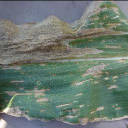

label_predicted:  not healthy
label_actual:  not_healthy


In [33]:
train_df_sample_list = train_df_sample.index.tolist()
rand_num_train = int(random.choice(train_df_sample_list))
rand_filepath_train = train_df_sample['filepaths'][rand_num_train]
rand_label_train = train_df_sample['labels'][rand_num_train]
rand_health_label_train = train_df_sample['health_label'][rand_num_train]
rand_label_pred_train = train_df_sample['label_predicted'][rand_num_train]
show_random_image(rand_filepath_train, rand_label_train,
                  rand_health_label_train, rand_label_pred_train)

Testing a Random Leaf and Producing a Binary Classification.

In [34]:
test_df

,filepaths,labels
0,dataset/test/Apple___Apple_scab/00075aa8-d81a-...,Apple_scab
1,dataset/test/Apple___Apple_scab/00075aa8-d81a-...,Apple_scab
2,dataset/test/Apple___Apple_scab/00075aa8-d81a-...,Apple_scab
3,dataset/test/Apple___Apple_scab/01f3deaa-6143-...,Apple_scab
4,dataset/test/Apple___Apple_scab/0208f4eb-45a4-...,Apple_scab
...,...,...
17567,dataset/test/Tomato___healthy/fd061d12-644d-4a...,healthy
17568,dataset/test/Tomato___healthy/fdbbea63-18e0-40...,healthy
17569,dataset/test/Tomato___healthy/fe0b76dc-4263-4c...,healthy
17570,dataset/test/Tomato___healthy/fe8f8808-2631-49...,healthy


In [35]:
test_df_sample

,filepaths,labels
14317,dataset/test/Tomato___Late_blight/e5b328bf-1f1...,Late_blight
2538,dataset/test/Cherry_(including_sour)___Powdery...,Powdery_mildew
6165,dataset/test/Grape___Leaf_blight_(Isariopsis_L...,Leaf_blight_(Isariopsis_Leaf_Spot)
3547,dataset/test/Corn_(maize)___Cercospora_leaf_sp...,Cercospora_leaf_spot Gray_leaf_spot
12219,dataset/test/Strawberry___Leaf_scorch/5297eecc...,Leaf_scorch
...,...,...
14784,dataset/test/Tomato___Leaf_Mold/efc97ed0-2c07-...,Leaf_Mold
8930,"dataset/test/Pepper,_bell___healthy/342c87ae-d...",healthy
15855,dataset/test/Tomato___Target_Spot/39ce44af-475...,Target_Spot
3182,dataset/test/Cherry_(including_sour)___healthy...,healthy


In [36]:
test_images = test_df_sample.values.tolist()
print("test_images: ", test_images)
test_filepaths = [test_images[i][0] for i in range(len(test_images))]
#test_labels = [test_images[i][1] for i in range(len(test_images))]
test_labels = ['healthy' if test_images[i][1] == 'healthy' else 'not healthy' for i in range(len(test_images))]
test_df_sample['health_label'] = test_labels

test_x = file_to_img(test_filepaths)
print("type of train_x: ", type(test_x))
print("length of train_x: ", len(test_x))

test_images:  [['dataset/test/Tomato___Late_blight/e5b328bf-1f13-4831-bd63-b1bdb30f02d9___GHLB2 Leaf 8674.JPG', 'Late_blight'], ['dataset/test/Cherry_(including_sour)___Powdery_mildew/4c823529-3235-4215-b13d-e74c16ea761a___FREC_Pwd.M 0331_flipLR.JPG', 'Powdery_mildew'], ['dataset/test/Grape___Leaf_blight_(Isariopsis_Leaf_Spot)/450588a9-80f0-4fc7-85a2-7dd3f17ab26b___FAM_L.Blight 0795.JPG', 'Leaf_blight_(Isariopsis_Leaf_Spot)'], ['dataset/test/Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot/ae535bc2-e24f-437e-ba3c-661fb05c0173___RS_GLSp 4461.JPG', 'Cercospora_leaf_spot Gray_leaf_spot'], ['dataset/test/Strawberry___Leaf_scorch/5297eecc-3b42-42e6-87af-d01be13b3052___RS_L.Scorch 9910_flipLR.JPG', 'Leaf_scorch'], ['dataset/test/Grape___Esca_(Black_Measles)/6625dd3f-65b7-4eff-a24a-3e964fc793a1___FAM_B.Msls 1304_flipLR.JPG', 'Esca_(Black_Measles)'], ['dataset/test/Grape___Black_rot/93a283be-7304-41d4-ac1f-be703b4671ee___FAM_B.Rot 5012.JPG', 'Black_rot'], ['dataset/test/Apple___Black_rot/f9e

Convert test images and labels to Torch files.

In [37]:
health_check_test = [1.0 if test_df['labels'][i] == 'healthy' else 0.0 for i in range(len(test_labels))]
test_df_sample['health_label_num'] = health_check_test
#print("length of train_y: ", len(health_check_test))

test_x = torch.tensor(test_x)
#print("Shape test_x: ", test_x.shape)
test_x = test_x.reshape(test_x.shape[0], 3, test_x.shape[1], test_x.shape[2])
test_y = torch.tensor(health_check_test)
#print("Shape test_y: ", test_y.shape)
test_df_sample.head()

,filepaths,labels,health_label,health_label_num
14317,dataset/test/Tomato___Late_blight/e5b328bf-1f1...,Late_blight,not healthy,0.0
2538,dataset/test/Cherry_(including_sour)___Powdery...,Powdery_mildew,not healthy,0.0
6165,dataset/test/Grape___Leaf_blight_(Isariopsis_L...,Leaf_blight_(Isariopsis_Leaf_Spot),not healthy,0.0
3547,dataset/test/Corn_(maize)___Cercospora_leaf_sp...,Cercospora_leaf_spot Gray_leaf_spot,not healthy,0.0
12219,dataset/test/Strawberry___Leaf_scorch/5297eecc...,Leaf_scorch,not healthy,0.0


Accuracy and Predictions of Test Images

In [38]:
test_accuracy, test_pred = testAccuracy(test_x, test_y)
print("Test Accuracy: ", test_accuracy)
test_df_sample['label_predicted'] = test_pred
test_df_sample.head()

Test Accuracy:  89.46666666666667


,filepaths,labels,health_label,health_label_num,label_predicted
14317,dataset/test/Tomato___Late_blight/e5b328bf-1f1...,Late_blight,not healthy,0.0,not_healthy
2538,dataset/test/Cherry_(including_sour)___Powdery...,Powdery_mildew,not healthy,0.0,healthy
6165,dataset/test/Grape___Leaf_blight_(Isariopsis_L...,Leaf_blight_(Isariopsis_Leaf_Spot),not healthy,0.0,not_healthy
3547,dataset/test/Corn_(maize)___Cercospora_leaf_sp...,Cercospora_leaf_spot Gray_leaf_spot,not healthy,0.0,not_healthy
12219,dataset/test/Strawberry___Leaf_scorch/5297eecc...,Leaf_scorch,not healthy,0.0,not_healthy


Performing Predictions on random Test image.

path:  dataset/test/Squash___Powdery_mildew/d63cd74c-ad6b-4106-a64d-e57aa22e2afa___UMD_Powd.M 0169.JPG


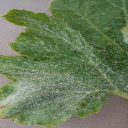

label_predicted:  not healthy
label_actual:  not_healthy


In [39]:
test_df_sample_list = test_df_sample.index.tolist()
rand_num_test = int(random.choice(test_df_sample_list))
rand_filepath_test = test_df_sample['filepaths'][rand_num_test]
rand_label_test = test_df_sample['labels'][rand_num_test]
rand_health_label_test = test_df_sample['health_label'][rand_num_test]
rand_label_pred_test = test_df_sample['label_predicted'][rand_num_test]
show_random_image(rand_filepath_test, rand_label_test,
                  rand_health_label_test, rand_label_pred_test)

---
## Creating a PDF version of your current notebook

In [40]:
#The following two installation steps are needed to generate a PDF version of the notebook
#(These lines are needed within Google Colab, but are not needed within a local version of Jupyter notebook)
!apt-get -qq install texlive texlive-xetex texlive-latex-extra pandoc
!pip install --quiet pypandoc

Extracting templates from packages: 100%
Preconfiguring packages ...
Selecting previously unselected package fonts-droid-fallback.
(Reading database ... 120880 files and directories currently installed.)
Preparing to unpack .../00-fonts-droid-fallback_1%3a6.0.1r16-1.1build1_all.deb ...
Unpacking fonts-droid-fallback (1:6.0.1r16-1.1build1) ...
Selecting previously unselected package fonts-lato.
Preparing to unpack .../01-fonts-lato_2.0-2.1_all.deb ...
Unpacking fonts-lato (2.0-2.1) ...
Selecting previously unselected package poppler-data.
Preparing to unpack .../02-poppler-data_0.4.11-1_all.deb ...
Unpacking poppler-data (0.4.11-1) ...
Selecting previously unselected package tex-common.
Preparing to unpack .../03-tex-common_6.17_all.deb ...
Unpacking tex-common (6.17) ...
Selecting previously unselected package fonts-urw-base35.
Preparing to unpack .../04-fonts-urw-base35_20200910-1_all.deb ...
Unpacking fonts-urw-base35 (20200910-1) ...
Selecting previously unselected package libgs9-co

In [41]:
# TO DO: Provide the full path to your Jupyter notebook file
!jupyter nbconvert --to PDF "/content/drive/My Drive/ECE5554_CVProject_Group11_LeafDisease/Project/LeafDisease_Souvik.ipynb"

[NbConvertApp] Converting notebook /content/drive/My Drive/ECE5554_CVProject_Group11_LeafDisease/Project/LeafDisease_Souvik.ipynb to PDF
[NbConvertApp] Support files will be in LeafDisease_Souvik_files/
[NbConvertApp] Making directory ./LeafDisease_Souvik_files
[NbConvertApp] Making directory ./LeafDisease_Souvik_files
[NbConvertApp] Making directory ./LeafDisease_Souvik_files
[NbConvertApp] Writing 1019850 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 788726 bytes to /content/drive/My Drive/ECE5554_CVProject_Group11_LeafDisease/Project/LeafDisease_Souvik.pdf
